In [83]:
# TODO make
import os
import io
import re
import glob
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import json

In [74]:


def extract_tables_from_file(filepath, start_marker_FID, start_marker_TCD, end_marker):
    with open(filepath, 'r', encoding='utf-16', errors='ignore') as f:
        lines = f.readlines()

    FID_table_lines = []
    TCD_table_lines = []
    inside_table = False
    FID = False
    TCD = False

    for line in lines:
        if start_marker_FID in line:
            inside_table = True
            FID = True
            continue  # skip the start line itself
        elif start_marker_TCD in line:
            inside_table = True
            TCD = True
            continue
        elif 'Injection Date' in line:
            injection_time = datetime.strptime(re.search(r'Injection Date\s+: ([\d/]+\s+\d{1,2}:\d{2}:\d{2}\s+[AP]M)', line).group(1),"%m/%d/%Y %I:%M:%S %p")
            continue

        # TODO fix logic (it works just looks dumb)
        if inside_table:
            if line.strip().startswith(end_marker) and FID and not TCD:  # In FID table
                FID = False
                inside_table = False  # end of table
            elif line.strip().startswith(end_marker) and not FID and TCD: # In TCD table
                TCD = False
                inside_table = False  # end of table
                if FID:
                    print('FID is still inside_table')
                break
            elif FID and not TCD:
                FID_table_lines.append(line.strip())
            else:
                TCD_table_lines.append(line.strip())

    return (FID_table_lines, TCD_table_lines), injection_time


In [51]:
file_path = r"C:\Users\flahertylab\OneDrive - Georgia Institute of Technology\Flaherty Research Group - ESS\02 - PFR Data\ESS-1-151_Eyring_Plots\05kPa O2\0ppmCl_5kPaO2\001F0101.D\REPORT.txt"

tables, injection_time = extract_tables_from_file(
    file_path,
    start_marker_FID="Signal 1: FID1 A,",
    start_marker_TCD="Signal 2: TCD2 B,",
    end_marker="Totals :"
)

# Preview
print(injection_time)
print("\n".join(tables[0]))
#print("\n".join(TCD_table))


7/18/2025 9:26:06 AM

Peak RetTime Type  Width     Area      Height     Area
#   [min]        [min]   [pA*s]      [pA]         %
----|-------|----|-------|----------|----------|--------|
1   0.501 BB    0.0710    2.28594 4.55914e-1  0.01608
2   1.664 BB S  0.0266 8596.02734 5261.25635 60.45309
3   1.907 BB T  0.0288 5275.73340 2884.62646 37.10253
4   4.357 BB    0.0652    2.31922 5.66720e-1  0.01631
5   4.863 BB    0.0593    1.36984 3.60590e-1  0.00963
6   6.739 BV    0.0374  339.65970  144.85747  2.38872
7   6.882 VB    0.0394    1.93895 7.09660e-1  0.01364


In [69]:
def convert_to_dataframe(data_tables, injection_number=None, injection_time=None):
    # Skip header, units, and separator
    FID_data = data_tables[0][4:]
    TCD_data = data_tables[1][4:]
    #data_lines = table_lines[4:]

    FID_df = PFR_parse_data(FID_data)
    TCD_df = PFR_parse_data(TCD_data)

    for df in (FID_df, TCD_df):
        df['Injection #'] = injection_number
        df['Injection Time'] = injection_time

    return FID_df, TCD_df


def PFR_parse_data(data):
    parsed_data = []
    for line in data:

        line = line.strip()

        match = re.match(
            r"(\d+)\s+([\d.]+)\s+([A-Z ]+?)\s+([\d.]+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+([\d.]+)", 
            line
        )
        if match:
            parsed_data.append(match.groups())
        else:
            print(f"❌ Failed to parse: {repr(line)}")


    column_names = ['Peak', 'RetTime [min]', 'Type', 'Width', 'Area', 'Height', 'Percent']
    df = pd.DataFrame(parsed_data, columns=column_names)

    for col in ['Peak', 'RetTime [min]', 'Width', 'Area', 'Height', 'Percent']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df


In [33]:
dfs = convert_to_dataframe(tables)


1   0.501 BB    0.0710    2.28594 4.55914e-1  0.01608
2   1.664 BB S  0.0266 8596.02734 5261.25635 60.45309
3   1.907 BB T  0.0288 5275.73340 2884.62646 37.10253
4   4.357 BB    0.0652    2.31922 5.66720e-1  0.01631
5   4.863 BB    0.0593    1.36984 3.60590e-1  0.00963
6   6.739 BV    0.0374  339.65970  144.85747  2.38872
7   6.882 VB    0.0394    1.93895 7.09660e-1  0.01364
1   0.397 BB S  0.0356 9149.63770 3799.34985 69.00905
2   0.543 BB X  0.0357 1919.12671  793.68048 14.47458
3   1.499 BB    0.0691  311.79675   70.46693  2.35166
4   2.502 BB    0.1160  889.69891  120.65175  6.71035
5   3.285 BB    0.1584  590.78546   58.22143  4.45586
6   5.027 BB    0.1917  332.99402   24.79430  2.51153
7   8.240 BB    0.1128   64.56530    8.83389  0.48697


In [17]:
y = '01'
print(int(y))

1


In [112]:
path = r"C:\Users\flahertylab\OneDrive - Georgia Institute of Technology\Flaherty Research Group - ESS\02 - PFR Data\ESS-1-151_Eyring_Plots\05kPa O2\0ppmCl_5kPaO2"

all_FID = []
all_TCD = []

for folder in os.listdir(path):
    if os.path.isdir(os.path.join(path,folder)) and folder.endswith('.D'):
        folder_path = os.path.join(path, folder)
        text_files = glob.glob(os.path.join(folder_path, 'REPORT.txt'))

        if not text_files:
            print(f'WARNING: {folder} does not have a REPORT file.')
            continue

        file_path  = text_files[0]

        with open(file_path, 'r', encoding='utf-16') as f:
            lines = f.readlines()
        
        data_tables, injection_time = extract_tables_from_file(file_path, start_marker_FID="Signal 1: FID1 A,", start_marker_TCD="Signal 2: TCD2 B,", end_marker="Totals :")
        
        
        injection_number, sequence_number = re.match(r'001F(\d{2})(\d{2})\.D', folder).groups()
        if int(sequence_number) != 1:
            print(f'WARNING: Sequence number {sequence_number} found, skipping folder')
            pass

        FID_df, TCD_df = convert_to_dataframe(data_tables, injection_number, injection_time)

        all_FID.append(FID_df)
        all_TCD.append(TCD_df)

FID_master = pd.concat(all_FID, ignore_index=True)
TCD_master = pd.concat(all_TCD, ignore_index=True)

FID_master.tail()
#TCD_master[TCD_master['Injection #']=='40'].head()

,Peak,RetTime [min],Type,Width,Area,Height,Percent,Injection #,Injection Time
816,2,0.541,VB,0.0473,0.592853,0.185372,0.00404,99,2025-07-19 09:44:00
817,3,1.654,BB S,0.0277,9245.706050,5346.065920,62.94554,99,2025-07-19 09:44:00
818,4,1.899,BB T,0.0314,5230.809570,2857.845950,35.61179,99,2025-07-19 09:44:00
819,5,6.737,BV,0.0360,208.653750,93.535860,1.42053,99,2025-07-19 09:44:00
820,6,6.873,VB,0.0399,0.991479,0.356951,0.00675,99,2025-07-19 09:44:00


In [86]:
test_df = FID_master

(101, 9)


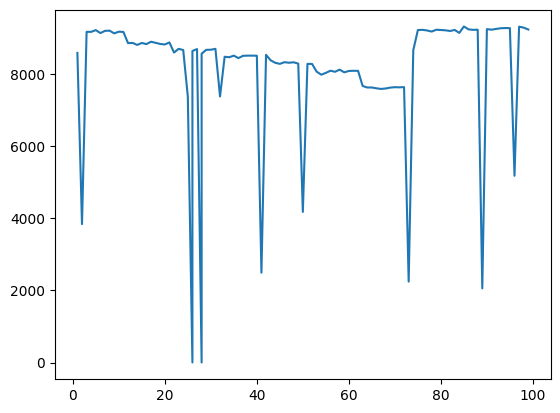

In [ ]:
with open('../FID_peaks.json','r') as f:
    RetTime = json.load(f)

FID_peak_dfs = {}

for peak_name, (low,high) in RetTime.items():
    mask = (low <= FID_master['RetTime [min]']) & (high >= FID_master['RetTime [min]'])
    peaks = FID_master[mask]
    FID_peak_dfs[peak_name] = peaks

ethane = FID_peak_dfs['Ethane']
ethylene = FID_peak_dfs['Ethylene'].dropna()
ethyl_Cl = FID_peak_dfs['Ethyl Choride']
EO = FID_peak_dfs['Ethylene Oxide']

plt.plot(ethylene['Injection #'].astype(int), ethylene['Area'])
print(ethylene.shape)

In [138]:
df = ethane
duplicates = df[df.duplicated(subset='Injection #', keep=False)]
duplicates

,Peak,RetTime [min],Type,Width,Area,Height,Percent,Injection #,Injection Time
560,4,1.897,VB S,0.0295,5260.55322,2789.290530,38.18268,62,2025-07-19 00:32:49
561,5,2.190,BB T,0.0493,1.90687,0.604253,0.01384,62,2025-07-19 00:32:49


In [149]:
with open('../TCD_peaks.json','r') as f:
    RetTime = json.load(f)

TCD_peak_dfs = {}

for peak_name, (low,high) in RetTime.items():
    mask = (low <= TCD_master['RetTime [min]']) & (high >= TCD_master['RetTime [min]'])
    peaks = TCD_master[mask]
    TCD_peak_dfs[peak_name] = peaks

oxygen = TCD_peak_dfs['Oxygen']
CO2 = TCD_peak_dfs['Carbon Dioxide']
CO2

,Peak,RetTime [min],Type,Width,Area,Height,Percent,Injection #,Injection Time
2,3,1.499,BB,0.0691,311.79675,70.46693,2.35166,01,2025-07-18 09:26:06
10,4,1.494,BB,0.0692,154.76462,34.91114,1.20476,02,2025-07-18 09:41:02
17,3,1.492,BB,0.0691,207.94583,47.01438,1.56778,03,2025-07-18 09:55:58
24,3,1.494,BB,0.0691,207.41289,46.87715,1.56393,04,2025-07-18 10:10:56
31,3,1.490,BB,0.0691,207.38971,46.90505,1.56336,05,2025-07-18 10:25:45
...,...,...,...,...,...,...,...,...,...
688,3,1.492,BB,0.0691,188.89680,42.69754,1.42781,95,2025-07-19 08:44:29
695,3,1.494,BB,0.0692,149.43138,33.72995,1.16352,96,2025-07-19 08:59:24
702,3,1.500,BB,0.0692,190.58795,43.03680,1.44264,97,2025-07-19 09:14:21
709,3,1.494,BB,0.0690,188.79355,42.77143,1.42661,98,2025-07-19 09:29:17


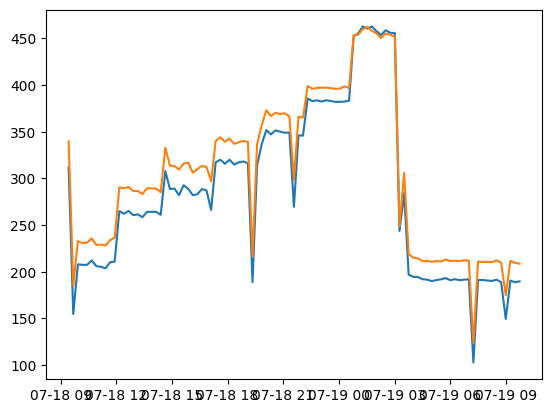

In [150]:
plt.plot(CO2['Injection Time'], CO2['Area'])
plt.plot(EO['Injection Time'], EO['Area'])